# Predicting Car Trim and Dealer Listing Price

The challenge is to build one or more models to predict vehicle trim and dealer listing price given the other twenty six variables provided.

Included in the training dataset is information on used cars previously sold. Each row corresponds to one used car listing. The first column of the data contains a unique identifier for the listing. The next twenty-six columns contain information on parameters relevant to the transaction, with those parameters described in more detail in the appendix attached. Finally, the last two columns of the `Training_dataset.csv` contain information on `Vehicle_Trim` and `Dealer_Listing_Price`, which describe the trim of the vehicle involved in the sale, and the price at which the vehicle was listed by the dealer.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline
import ast

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
import re

### Useful General functions

These are functions I used for my various data science projects

In [2]:
def log_transform(data, col):
    data['Log ' + col] = np.log(data[col])
    return data

def select_columns(data, *columns):
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    
    i = data[((data[variable] < lower) | (data[variable] > upper))].index
    return data.drop(i, inplace=False)

def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = 1*np.array([texts.str.contains(word) for word in words]).T
    return indicator_array


def ohe_generator(data, columns):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    for column in columns:
        dummies = pd.get_dummies(data[column], prefix=column)
    return dummies

def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')
    
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))


def frequency_plot(some_words, function, data, columnName):
    Phi_train = function(some_words, data[columnName])
    df = pd.DataFrame(data=Phi_train, columns=some_words)
    df['label'] = data['Vehicle_Trim']

    plt.figure(figsize=(16,8))
    sns.barplot(x = "variable", 
                y = "value", 
                hue = "label",
                data = (df.melt('label')
                        .groupby(['label', 'variable'])
                        .mean()
                        .reset_index())
               )
    plt.xlabel(columnName)
    plt.ylabel('Proportion of Words')
    plt.legend(title = "", loc="upper right", prop={'size': 12}, bbox_to_anchor=(1.3, 1.05))
    title = "Frequency of words in " + columnName 
    plt.title(title)
    plt.show()
    
    
def evaluate(x):
    """
    This function evaluates an expression node or a string consisting 
    of a Python literal or container display.
    """
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        return []

### Useful data-specific function

Functions I created for this specific data

In [3]:
def clean_drive_train(train):
    """
    function that cleans up vehDriveTrain column by grouping them properly.
    """
    train.loc[(train["VehDriveTrain"] == "Front Wheel Drive"), ["VehDriveTrain"]] = "FWD"
    train.loc[(train["VehDriveTrain"] == "Front-wheel Drive"), ["VehDriveTrain"]] = "FWD"
    train.loc[(train["VehDriveTrain"] == "FRONT-WHEEL DRIVE"), ["VehDriveTrain"]] = "FWD"
    
    train.loc[(train["VehDriveTrain"] == "AllWheelDrive"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "ALL WHEEL"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "All-wheel Drive"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "All-wheel Drive"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "All Wheel Drive"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL"), ["VehDriveTrain"]] = "AWD"
    train.loc[(train["VehDriveTrain"] == "ALL-WHEEL DRIVE"), ["VehDriveTrain"]] = "AWD"

    train.loc[(train["VehDriveTrain"] == "4X4"), ["VehDriveTrain"]] = "4WD"
    train.loc[(train["VehDriveTrain"] == "4x4"), ["VehDriveTrain"]] = "4WD"
    train.loc[(train["VehDriveTrain"] == "4x4/4-wheel drive"), ["VehDriveTrain"]] = "4WD"
    train.loc[(train["VehDriveTrain"] == "4x4/4WD"), ["VehDriveTrain"]] = "4WD"
    train.loc[(train["VehDriveTrain"] == "Four Wheel Drive"), ["VehDriveTrain"]] = "4WD"

    train.loc[(train["VehDriveTrain"] == "AWD or 4x4"), ["VehDriveTrain"]] = "4WD/AWD"
    return train



def make_engine_size(train):
    """
    Extract Engine Size from VehEngine Column
    """
    pattern = r"(\d*\.?\d+ ?l)"
    train['VehEngineSize'] = train["VehEngine"].str.extract(pattern)
    train['VehEngineSize'] = train['VehEngineSize'].fillna('unknown')
    
    train.loc[(train["VehEngineSize"] == "3.0 l"), ["VehEngineSize"]] = "3.0l"
    train.loc[(train["VehEngineSize"] == "3.6 l"), ["VehEngineSize"]] = "3.6l"
    train.loc[(train["VehEngineSize"] == "5.7 l"), ["VehEngineSize"]] = "5.7l"
    train.loc[(train["VehEngineSize"] == "6.2 l"), ["VehEngineSize"]] = "6.2l"
    train.loc[(train["VehEngineSize"] == "6.4 l"), ["VehEngineSize"]] = "6.4l"
    return train



def make_cylinder_count(train):
    """
    Extracts cylinder count from VehEngine Column
    """

    pattern = r"(\d*[ -]?cyl)"

    train['VehCylCount'] = train["VehEngine"].str.extract(pattern)
    train['VehCylCount'] = train['VehCylCount'].fillna('unknown')
    train.loc[(train["VehCylCount"] == "6-cyl"), ["VehCylCount"]] = "6 cyl"
    train.loc[(train["VehCylCount"] == "8-cyl"), ["VehCylCount"]] = "8 cyl"
    
    return train

def extract_features(data):
    sample = data['VehFeats'].apply(lambda x: evaluate(x))
    feats = pd.DataFrame(sample.explode())
    raw_feats = pd.DataFrame(feats.groupby('VehFeats').size().sort_values(ascending=False).iloc[:120])
    raw_feats.reset_index(inplace=True)
    return raw_feats['VehFeats'].tolist()


## Vehicle Trim

My initial plan is to create a model for vehicle trim using a Decision Tree classifier.

In [4]:
train_1 = pd.read_csv('Training_DataSet.csv')
tr = pd.read_csv('Training_DataSet.csv')
test = pd.read_csv('Test_DataSet.csv')

#Extracting the rows that dont have null values in Vehicle_Trim Column
tr = tr[tr['Vehicle_Trim'].notna()]

# Convert the vehicle features and vehicle notes to lower case as a first step to processing the text
tr['VehFeats'] = tr['VehFeats'].str.lower()
tr['VehFeats'] = tr['VehFeats'].fillna('')

tr['VehSellerNotes'] = tr['VehSellerNotes'].str.lower()
tr['VehSellerNotes'] = tr['VehSellerNotes'].fillna('')

tr["SellerZip"] = tr["SellerZip"].fillna(0).astype(int)
tr.drop(['ListingID'], axis=1, inplace=True)
tr.reset_index(inplace=True, drop=True)

tr.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,...,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
0,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091,SUV,False,...,Jeep,39319.0,Grand Cherokee,Fair Price,,Used,Automatic 8-Speed,2015,High Altitude,30990.0
1,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186,SUV,True,...,Jeep,38957.0,Grand Cherokee,Good Deal,backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
2,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385,SUV,False,...,Jeep,20404.0,Grand Cherokee,Good Deal,drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
3,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703,SUV,False,...,Cadillac,19788.0,XT5,Good Deal,"luxury, exterior parking camera rear, front du...",Used,8-Speed Automatic,2018,Luxury,33495.0
4,Olean,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760,SUV,False,...,Jeep,34649.0,Grand Cherokee,Good Deal,priced below kbb fair purchase price! clean ca...,Used,8-Speed Automatic,2018,Limited,27900.0


### EDA

In [5]:
tr.isnull().sum()

SellerCity                0
SellerIsPriv              0
SellerListSrc             2
SellerName                0
SellerRating              0
SellerRevCnt              0
SellerState               0
SellerZip                 0
VehBodystyle              0
VehCertified              0
VehColorExt              47
VehColorInt             441
VehDriveTrain            68
VehEngine                28
VehFeats                  0
VehFuel                   2
VehHistory              201
VehListdays               2
VehMake                   0
VehMileage                2
VehModel                  0
VehPriceLabel           285
VehSellerNotes            0
VehType                   0
VehTransmission          32
VehYear                   0
Vehicle_Trim              0
Dealer_Listing_Price     52
dtype: int64

In [6]:
print("number of rows", len(tr))

number of rows 5893


<AxesSubplot:>

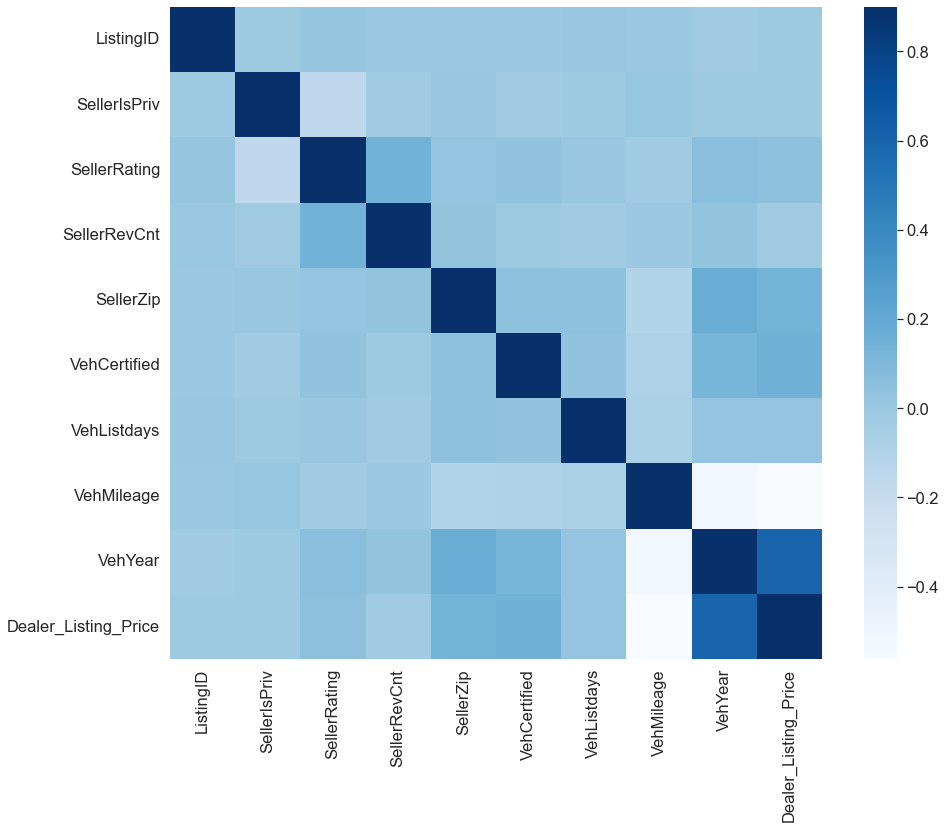

In [7]:
corr = train_1.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [8]:
extract_features(tr)[0:5]

['audio controls on steering wheel',
 '4-wheel abs brakes',
 'abs and driveline traction control',
 '1st and 2nd row curtain head airbags',
 'braking assist']

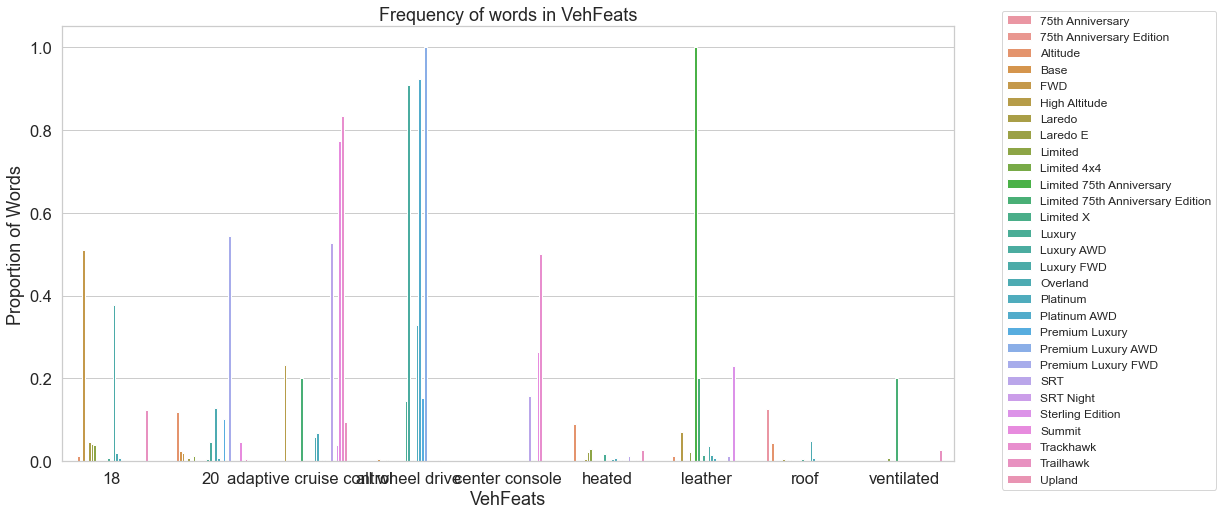

In [9]:
frequency_plot(["all wheel drive", "adaptive cruise control", "center console", "leather", "18", "20", "ventilated", "heated", "roof"], words_in_texts, tr, "VehFeats")

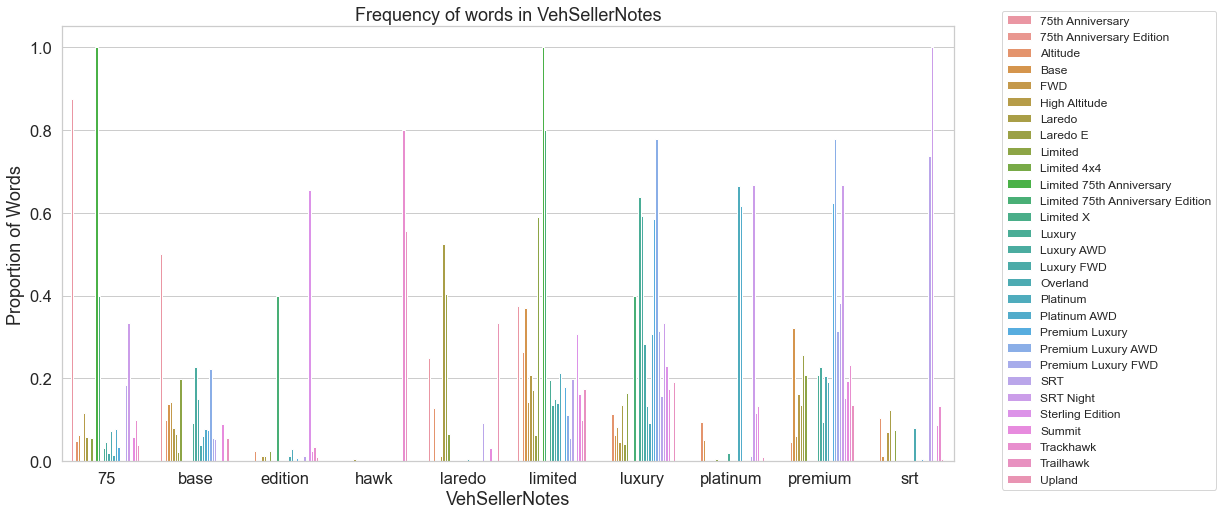

In [10]:
frequency_plot(["luxury", "premium", "edition", "75", "platinum", "base", "laredo", "srt", "edition", "limited", "hawk"], words_in_texts, tr, "VehSellerNotes")

In [11]:
vehicle_trim = train_1[train_1['Vehicle_Trim'].notna()]['Vehicle_Trim'].unique().tolist()
vehicle_trim

['High Altitude',
 'Laredo',
 'Limited',
 'Luxury',
 'Limited 4x4',
 'Altitude',
 'Overland',
 'Premium Luxury',
 'Base',
 'Summit',
 'FWD',
 'SRT',
 'Luxury AWD',
 'Trailhawk',
 'Sterling Edition',
 'Platinum',
 'Laredo E',
 'Luxury FWD',
 'Trackhawk',
 '75th Anniversary',
 'Premium Luxury FWD',
 'Platinum AWD',
 'SRT Night',
 'Limited 75th Anniversary Edition',
 '75th Anniversary Edition',
 'Limited 75th Anniversary',
 'Premium Luxury AWD',
 'Upland',
 'Limited X']

Saved the list of vehicle trim to be used when searching relevant words in `VehSellerNotes` column

### Data Processing

In [12]:
def process_data_tree(train, vehicle_trim, is_test_set=False):
    
    if is_test_set == False:
        train = train[train['Vehicle_Trim'].notna()]
    
    # Convert the string-type column as a first step to processing the text
    train['VehFeats'] = train['VehFeats'].str.lower()
    train['VehFeats'] = train['VehFeats'].fillna('')
    

    train['VehSellerNotes'] = train['VehSellerNotes'].str.lower()
    train['VehSellerNotes'] = train['VehSellerNotes'].fillna('')

    train["VehEngine"] = train["VehEngine"].str.lower()
    train['VehEngine'] = train['VehEngine'].fillna('')

    
    #Impute Missing Value
    train['VehFuel'] = train['VehFuel'].fillna('Unknown')
    train["VehDriveTrain"] = train["VehDriveTrain"].fillna('unknown')
    
    #Clean up Vehicle Drive Train Data
    train = clean_drive_train(train)
    
    #Extract Engine Size 
    train = make_engine_size(train)
    
    #Extract Cylinder Count
    train = make_cylinder_count(train)
    
    
    #words in text
    features = extract_features(train)
    sellerNotes = features + vehicle_trim
    vehFeats = words_in_texts(features, train["VehFeats"])
    vehNote = words_in_texts(sellerNotes, train["VehSellerNotes"])
    vehFeats_df = pd.DataFrame(vehFeats, columns=features)
    sellerNotesCol = ["seller_" + s for s in sellerNotes]
    vehNote_df = pd.DataFrame(vehNote, columns=sellerNotesCol)
    
    columns = ['VehMake',
           'VehYear']
    
    design_matrix = select_columns(train, *columns)
    
    #one hot encoded variables
    drive_train = ohe_generator(train, ['VehDriveTrain'])
    design_matrix = design_matrix.join(drive_train)
    vehMake = ohe_generator(train, ['VehMake'])
    design_matrix = design_matrix.join(vehMake)
    vehFuel = ohe_generator(train, ['VehFuel'])
    design_matrix = design_matrix.join(vehFuel)
    vehYear = ohe_generator(train, ['VehYear'])
    design_matrix = design_matrix.join(vehYear)
    vehEngineSize = ohe_generator(train, ['VehEngineSize'])
    design_matrix = design_matrix.join(vehEngineSize)
    vehCylCount = ohe_generator(train, ['VehCylCount'])
    design_matrix = design_matrix.join(vehCylCount)
    
    design_matrix = design_matrix.reset_index(drop=True)
    
    design_matrix = design_matrix.join(vehFeats_df)
    design_matrix = design_matrix.join(vehNote_df)
    
    
    drop_columns = columns + ['VehFuel_Unknown', "VehDriveTrain_2WD"]
    design_matrix = design_matrix.drop(drop_columns, axis = 1, errors='ignore')
    
    return design_matrix

In [13]:
X_train = process_data_tree(train_1, vehicle_trim)
sample_train_1 = train_1[train_1['Vehicle_Trim'].notna()]
Y_train = sample_train_1["Vehicle_Trim"]

/Users/elle/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


### Hyperparameter Tuning

#### Grid Search

In [14]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

dt_hp = tree.DecisionTreeClassifier(random_state = 42)

params = {'max_depth':[10, 20, 25, 30, 35, 40, 45],
          'min_samples_leaf':[1, 2, 5, 10, 15, 20],
          'min_samples_split':[3, 4, 8, 10, 18, 20],
          'criterion':['gini','entropy'],
          'max_features':['int', 'float' 'auto', 'sqrt', 'log2', None]}
GS = GridSearchCV(estimator=dt_hp, param_grid=params,cv=5, n_jobs=-1, verbose=True, scoring='accuracy')

In [15]:
GS.fit(X_train, Y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5040 fits failed out of a total of 12600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5040 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elle/Library/Python/3.8/lib/python/site-packages/sklear

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 25, 30, 35, 40, 45],
                         'max_features': ['int', 'floatauto', 'sqrt', 'log2',
                                          None],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20],
                         'min_samples_split': [3, 4, 8, 10, 18, 20]},
             scoring='accuracy', verbose=True)

In [16]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 35, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}

Best Score: 0.8562722574309038


#### Random Search

In [17]:
from sklearn.model_selection import RandomizedSearchCV

dt_hp_RS = tree.DecisionTreeClassifier(random_state=42)
RS = RandomizedSearchCV(estimator=dt_hp_RS,param_distributions=params,cv=5,n_iter=2520,n_jobs=-1, verbose=True, scoring='accuracy')

In [18]:
RS.fit(X_train, Y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5040 fits failed out of a total of 12600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5040 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elle/Library/Python/3.8/lib/python/site-packages/sklear

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=2520, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 25, 30, 35, 40,
                                                      45],
                                        'max_features': ['int', 'floatauto',
                                                         'sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [3, 4, 8, 10, 18,
                                                              20]},
                   scoring='accuracy', verbose=True)

In [19]:
print('Best Parameters:',RS.best_params_,end='\n\n')
print('Best Score:',RS.best_score_)

Best Parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 35, 'criterion': 'gini'}

Best Score: 0.8562722574309038


### Modeling and Cross Validation

In [20]:
from sklearn.model_selection import cross_val_score

decision_tree_clf = tree.DecisionTreeClassifier(criterion ='gini', 
                                                max_depth = 35, 
                                                min_samples_leaf=1, 
                                                min_samples_split=4)
decision_tree_clf = decision_tree_clf.fit(X_train, Y_train)


y_pred = decision_tree_clf.predict(X_train)
decision_tree_training_accuracy = decision_tree_clf.score(X_train, Y_train)
print("Decision Tree Training Accuracy: ", decision_tree_training_accuracy)
scores = cross_val_score(decision_tree_clf, X_train, Y_train, cv=5)
print("Decision Tree Classifier Average Accuracy After 5-KFold Cross Validation",scores.mean())

Decision Tree Training Accuracy:  0.9487527575089089


/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree Classifier Average Accuracy After 5-KFold Cross Validation 0.8576297717123802


### Confusion Matrix

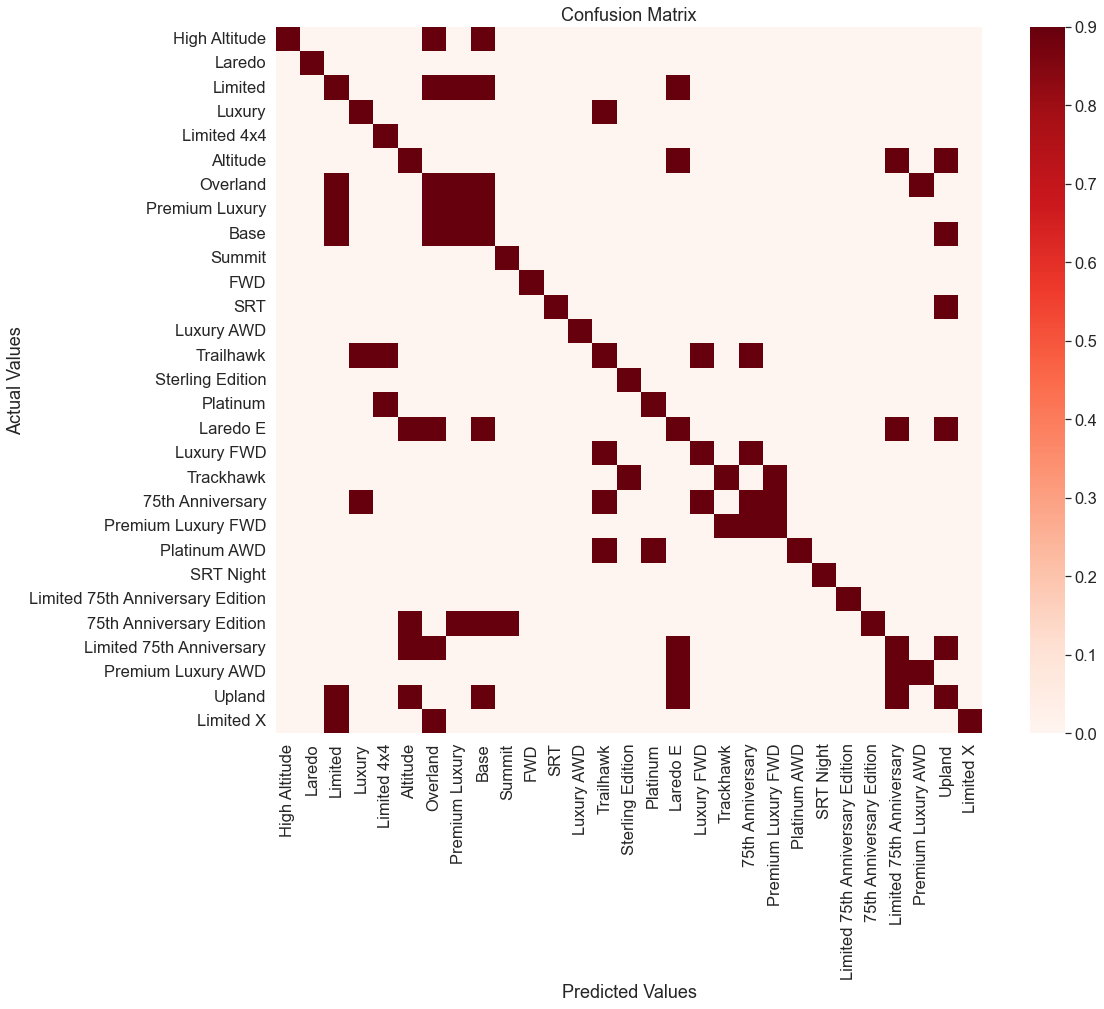

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_train, y_pred)
cm_df = pd.DataFrame(cm, index = Y_train.unique(), columns=Y_train.unique())
cm_df 

#Plotting the confusion matrix
plt.figure(figsize=(17,13))
sns.heatmap(cm_df, vmax=0.9, cmap="Reds", square=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Predicting Vehicle Trim for Test Data

In [22]:
#Creating Design Matrix
X_test_dt = process_data_tree(test, vehicle_trim, is_test_set=True)
temp_predict = decision_tree_clf.predict(X_test_dt)
Trim = pd.DataFrame(data=temp_predict, columns=["Vehicle_Trim"])
Trim

/Users/elle/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/elle/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 6 speakers
- 8-way power adjustable drivers seat
- adaptive cruise control w/stop
- advanced technology group-inc: advanced brake assistadaptive cruise control w/stopblind spot &amp; cross path detectionforward collision warning plus
- altitude iii package-inc: black roof moldingmic black bezelsdark lens taillampsdelete laredo badge
- ...
Feature names seen at fit time, yet now missing:
- altitude iii package
- am/fm/cd stereo system
- apple carplay and android auto
- bose audio system
- bose premium audio system
- ...

  warnings.war

,Vehicle_Trim
0,Platinum
1,Limited
2,Limited
3,Limited
4,Luxury
...,...
995,Limited
996,Luxury
997,Platinum
998,Sterling Edition


## Dealer Listing Price

In [23]:
#Reading txt and csv file
train_2 = pd.read_csv('Training_DataSet.csv')
train_2 = train_2[train_2['Vehicle_Trim'].notna()]
train_2["trim"] = y_pred

### EDA

/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


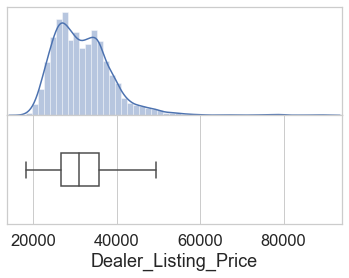

In [24]:
plot_distribution(train_2, label='Dealer_Listing_Price');

From this distribution, I can see that I need to apply log transformation to normalized the data.

/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


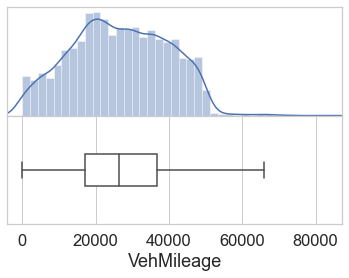

In [25]:
plot_distribution(train_2, label='VehMileage')

Correlation of VehMileage and Dealer Listing Price -0.5627563791194728


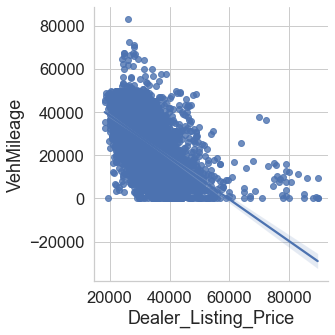

In [26]:
sns.lmplot(x="Dealer_Listing_Price", y="VehMileage", data=train_2);
print("Correlation of VehMileage and Dealer Listing Price", train_2["VehMileage"].corr(train_2["Dealer_Listing_Price"]))

/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/elle/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


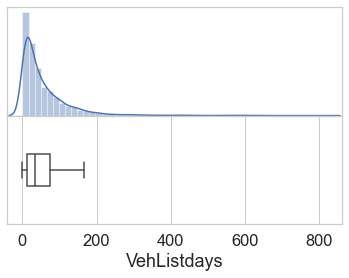

In [27]:
plot_distribution(train_2, label='VehListdays');

Correlation of VehListdays and Dealer Listing Price 0.011619814980916646


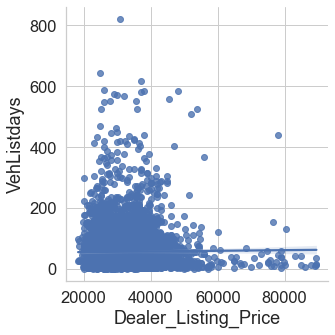

In [28]:
sns.lmplot(x="Dealer_Listing_Price", y="VehListdays", data=train_2);
print("Correlation of VehListdays and Dealer Listing Price", train_2["VehListdays"].corr(train_2["Dealer_Listing_Price"]))

Correlation of SellerRating and Dealer Listing Price 0.04953549606845552


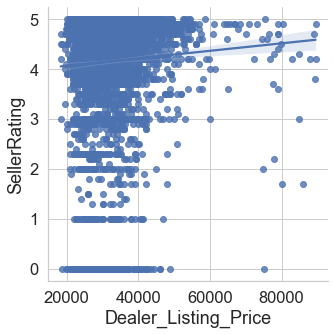

In [29]:
sns.lmplot(x="Dealer_Listing_Price", y="SellerRating", data=train_2);
print("Correlation of SellerRating and Dealer Listing Price", train_2["SellerRating"].corr(train_2["Dealer_Listing_Price"]))

In [30]:
features = extract_features(tr)

### Linear Regression Model

In [31]:
def process_data_lm(train_data, vehicle_trim, features, is_test_set=False):
    
    if is_test_set == False:
        train_data = train_data[train_data['Dealer_Listing_Price'].notna()]
    
    #removing the outliers
    if is_test_set == False:
        train_data = remove_outliers(train_data, 'Dealer_Listing_Price', upper=60000)
        
    #Impute NAs
    temp_data = remove_outliers(train_data, 'VehMileage', lower = 1)
    average_mileage = temp_data["VehMileage"].mean()
    train_data["VehMileage"] = train_data["VehMileage"].fillna(average_mileage)
    train_data.loc[(train_data["VehMileage"] == 0), ["VehMileage"]] = average_mileage
    
    temp_data = remove_outliers(train_data, 'VehListdays', lower = 5, upper=500)
    average_listingdays = temp_data["VehListdays"].mean()
    train_data["VehListdays"] = train_data["VehListdays"].fillna(average_listingdays)
    
    train_data["VehPriceLabel"] = train_data["VehPriceLabel"].fillna('unknown')
    
    
    # Convert the string-type column as a first step to processing the text
    train_data['VehFeats'] = train_data['VehFeats'].str.lower()
    train_data['VehFeats'] = train_data['VehFeats'].fillna('')

    train_data['VehHistory'] = train_data['VehHistory'].str.lower()
    train_data['VehHistory'] = train_data['VehHistory'].fillna('')

    train_data['VehSellerNotes'] = train_data['VehSellerNotes'].str.lower()
    train_data['VehSellerNotes'] = train_data['VehSellerNotes'].fillna('')
    
    train_data["VehEngine"] = train_data["VehEngine"].str.lower()
    train_data["VehEngine"] = train_data["VehEngine"].fillna('')
    
    
    #Extract Vehicle Owners from Vehicle History using regex
    pattern = r"(\d*)[ -]?owner"
    train_data['VehOwnerCount'] = train_data['VehHistory'].str.extract(pattern)
    train_data['VehOwnerCount'] = train_data['VehOwnerCount'].fillna('unknown')
    
    #Check for accident reports in Vehicle History
    pattern = r"(accident)"
    train_data["VehAccidentExist"] = 1 * (train_data['VehHistory'].str.extract(pattern) == "accident")
    
    #Clean up Vehicle Drive Train Data
    train_data = clean_drive_train(train_data)
    
    #Extract Engine Size 
    train_data = make_engine_size(train_data)
    
    #Extract Cylinder Count
    train_data = make_cylinder_count(train_data)
    
    #Adding Log Transformation
    if is_test_set == False:
        log_transform(train_data, 'Dealer_Listing_Price')
    log_transform(train_data, 'VehMileage')
    
    #words in text
    sellerNotes = features + vehicle_trim
    vehFeats = words_in_texts(features, train_data["VehFeats"])
    vehNote = words_in_texts(sellerNotes, train_data["VehSellerNotes"])
    vehFeats_df = pd.DataFrame(vehFeats, columns=features)
    sellerNotesCol = ["seller_" + s for s in sellerNotes]
    vehNote_df = pd.DataFrame(vehNote, columns=sellerNotesCol)
    
    
    if is_test_set == False:
            columns = ['Log Dealer_Listing_Price',
               'Log VehMileage',
               'VehListdays',
               'VehAccidentExist',
               'VehCertified'
              ]
    else:
        columns = ['Log VehMileage',
           'VehListdays',
           'VehAccidentExist',
           'VehCertified'
          ]
        
    design_matrix = select_columns(train_data, *columns)
    
    #Changing Boolean Data type to Integer
    design_matrix["VehCertified"] = 1*(design_matrix["VehCertified"])
    
    #one hot encoded variables
    vehMake = ohe_generator(train_data, ['VehMake'])
    design_matrix = design_matrix.join(vehMake)
    vehPriceLabel = ohe_generator(train_data, ["VehPriceLabel"])
    design_matrix = design_matrix.join(vehPriceLabel)
    vehOwnerCount = ohe_generator(train_data, ["VehOwnerCount"])
    design_matrix = design_matrix.join(vehOwnerCount)
    vehDriveTrain = ohe_generator(train_data, ["VehDriveTrain"])
    design_matrix = design_matrix.join(vehDriveTrain)
    vehYear = ohe_generator(train_data, ["VehYear"])
    design_matrix = design_matrix.join(vehYear)
    vehEngineSize = ohe_generator(train_data, ["VehEngineSize"])
    design_matrix = design_matrix.join(vehEngineSize)
    vehCylCount = ohe_generator(train_data, ["VehCylCount"])
    design_matrix = design_matrix.join(vehCylCount)
    vehFuel = ohe_generator(train_data, ["VehFuel"])
    design_matrix = design_matrix.join(vehFuel)
    sellerListSrc = ohe_generator(train_data, ["SellerListSrc"])
    design_matrix = design_matrix.join(sellerListSrc)
    trim = ohe_generator(train_data, ["trim"])
    design_matrix = design_matrix.join(trim)
    
    design_matrix = design_matrix.reset_index(drop=True)
    
    design_matrix = design_matrix.join(vehFeats_df)
    design_matrix = design_matrix.join(vehNote_df)
    
    drop_columns = ["VehEngineSize_6.2l", "SellerListSrc_Five Star Certified Program", "VehDriveTrain_2WD", "VehFuel_Unknown", "VehOwnerCount_4", "VehDriveTrain_unknown", "SellerListSrc_Cadillac Certified Program"]
    design_matrix = design_matrix.drop(drop_columns, axis = 1, errors='ignore')
    if is_test_set == False:
        # Return predictors and response variables separately
        X = design_matrix.drop(['Log Dealer_Listing_Price'], axis = 1)
        y = design_matrix.loc[:, 'Log Dealer_Listing_Price']
    else:
        X = design_matrix
        y = []
    
    return X, y, design_matrix

In [32]:
#Creating Design Matrix
train_2["trim"] = Trim
X_train, y_train, design_matrix = process_data_lm(train_2, vehicle_trim, features)

/Users/elle/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Adding the predicted vehicle trim from the first model to be used as another feature.

### Modeling and Cross Validation

In [33]:
from sklearn import linear_model as lm
from sklearn.metrics import f1_score
from sklearn import metrics


linear_model = lm.LinearRegression(fit_intercept=True, n_jobs=1)
linear_model.fit(X_train, y_train)

y_predicted_train = linear_model.predict(X_train)
training_rmse = rmse(np.exp(y_predicted_train), np.exp(y_train))
normalized_rmse = training_rmse/(89500-18289)
mae = metrics.mean_absolute_error(y_train, y_predicted_train)
mse = metrics.mean_squared_error(y_train, y_predicted_train)
r2 = metrics.r2_score(y_train, y_predicted_train)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(training_rmse))
print('Normalized RMSE is {}'.format(normalized_rmse))
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 2466.117413710604
Normalized RMSE is 0.03463113021458208
MAE is 0.0562614397481115
MSE is 0.0056186436120500985
R2 score is 0.859892334684141


In [34]:
from sklearn.model_selection import KFold

def cross_validate_rmse(model, data):

    X_train, y_train, design_matrix =process_data_lm(data, vehicle_trim, features)
   
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(design_matrix):
        
        X_tr = X_train.iloc[tr_ind,:]
        y_tr = y_train.iloc[tr_ind]
        X_val = X_train.iloc[va_ind, :]
        y_val = y_train.iloc[va_ind]
        
        model.fit(X_train, y_train)
        y_predicted_tr = model.predict(X_val)
        rmse_val = rmse(np.exp(y_predicted_tr), np.exp(y_val))
        rmse_values.append(rmse_val)
    return np.mean(rmse_values)

In [35]:
micah_linear_model = lm.LinearRegression(fit_intercept=True)
print("mean rmse after 5-Fold Cross Validation: ", cross_validate_rmse(micah_linear_model, train_2))

/Users/elle/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


mean rmse after 5-Fold Cross Validation:  2464.9862900361604


### Predicting Dealer_Listing_Price for Test Data

In [36]:
#Adding the predicted vehicle trim to our test data
test["trim"] = Trim


#Creating Design Matrix
X_test_lm, y_test, design_matrix = process_data_lm(test, vehicle_trim, features, is_test_set=True)

/Users/elle/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [37]:
dealer_listing_price_predict = np.exp(micah_linear_model.predict(X_test_lm))

<ipython-input-37-80a738b3259a>:1: RuntimeWarning: overflow encountered in exp
  dealer_listing_price_predict = np.exp(micah_linear_model.predict(X_test_lm))


In [38]:
Dealer_Listing_Price = pd.DataFrame(data=dealer_listing_price_predict, columns=["Dealer_Listing_Price"])
ListingID = pd.DataFrame(data=test["ListingID"], columns=["ListingID"])
predict = ListingID.join(Trim).join(Dealer_Listing_Price)
predict

,ListingID,Vehicle_Trim,Dealer_Listing_Price
0,8622015,Platinum,38627.064025
1,8625693,Limited,25309.451493
2,8625750,Limited,23980.327145
3,8626885,Limited,25766.163972
4,8627430,Luxury,40407.319525
...,...,...,...
995,9992442,Limited,29352.016482
996,9993562,Luxury,34818.789390
997,9994646,Platinum,38263.576718
998,9997199,Sterling Edition,48570.099219


In [39]:
predict.to_csv('Micah_Feras.csv', index=False, header=False)